In [60]:
#Import all the relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

In [74]:
#Set up user defined constants and file info
NCmetadatafile = '220211_2M1F_NaiveChoice_metadata.csv'
FCmetadatafile = '220211_2F1M_final_metadata.csv'
huddle_time = 20 #ms (Value taken from Nerissa though there is much debate about whether this is correct)
PPI_floor = 0.75 #value taken from Kim

make_duplicate_plots = True

In [75]:
#Define support functions in this cell
def check_files_versus_metadata():
    return

def extract_lane_info(file_list):
    extracted_names = []
    for file in range(0, len(file_list),1):
        components = file_list[file].split('_')
        for l in range(0, len(components),1):
            if "Lane" in components[l]:
                extracted_names.append(components[l])
    return extracted_names

def adjacent_columns(file_list):
    num_adjacentcolumns = []
    names = extract_lane_info(file_list)
    for name in names:
        if re.search('Lane1|Lane4', name):
            num_adjacentcolumns.append(1)
        else:
            num_adjacentcolumns.append(2)
    return num_adjacentcolumns
    
def calculate_PPI(datafile):
    #calculate time huddling
    time_huddling_right = []
    time_huddling_left = []
    for i in range(0, len(datafile),1):
        row = datafile.loc[i]
        timecontactright = row.Contact_Right_stop - row.Contact_Right_start
        timecontactleft = row.Contact_Left_stop - row.Contact_Left_start
        if timecontactright >= huddle_time:
            time_huddling_right.append(timecontactright)
        if timecontactleft >= huddle_time:
            time_huddling_left.append(timecontactleft)
    total_huddle_time_right = np.nansum(time_huddling_right)
    total_huddle_time_left = np.nansum(time_huddling_left)
    PPI = (total_huddle_time_right - total_huddle_time_left)/(total_huddle_time_right + total_huddle_time_left)
    return PPI

def calculate_winner(datafile):
    if calculate_PPI(datafile) >= PPI_floor:
        return 'Right'
    elif calculate_PPI(datafile) <= -(PPI_floor):
        return 'Left'
    else:
        return 'None'
    
#PLOTTING FUNCTIONS
    
def relplot (datatable, xaxis, yaxis, plottype = 'scatter'):
    #Unless specified, default relplot is scatter
    sns.relplot(
    data = datatable, kind = plottype,
    x = xaxis, y = yaxis, #col = "time", 
    #hue = "Left", style = 'Left', size = 'size'
    )
    return
def displot(datatable, xaxis, yaxis, plottype = 'hist'):
    #Unless specified, default displot is histogram
    sns.displot(
        data = datatable, 
        kind = plottype, 
        x = xaxis,
        y = yaxis, #col = "time", 
        #color = color #"Left", style = 'Left', size = 'size'
    )
    return


In [76]:
#Handle the raw data files for naive choice

# 1 - Generate a list of all the files to work on
#Import metadata as a DataFrame
NCmetadatatable = pd.read_csv(NCmetadatafile)

#Define the file path for this data files
data_dir = os.path.join('C:\\','Users','vashv','OneDrive','Documents','GitHub','ppt-lanes','data_files')


#Create a list of files for this project
NC_all_files = []
NC_all_files += [os.path.join(data_dir, each) for each in os.listdir(data_dir) if 'NaiveChoice' in each]



# 2 - Set up places to store all your eventual calculations
winner_column = []
PPI_column = []

# 3 - Iterate over that list

for file in NC_all_files:
    #Load data
    thisdata = pd.read_csv(file)
    #do all computations by calling functions
    thisPPI = calculate_PPI(thisdata)
    thiswinner = calculate_winner(thisdata)
    #put all of my file calculations in group data table
    PPI_column.append(thisPPI)
    winner_column.append(thiswinner)

# Consolidate all your calculations into one big table

#Done because data is missing
NCtable = NCmetadatatable.drop(6)

#Insert Lane information
NCtable.insert(loc = 0,
              column = 'Lane',
              value = extract_lane_info(NC_all_files))
#Insert number of adjacent columns (really the independent variable here)
NCtable.insert(loc = 1,
              column = '# Adjacent Columns',
              value = adjacent_columns(NC_all_files))
NCtable['PPI'] = PPI_column
#Absolute PPI removed Left/Right and just allows you to look at strong/weak partner preference
NCtable.insert(loc = 7,
               column = 'Absolute PPI',
               value = abs(NCtable['PPI']))
NCtable['Winner'] = winner_column
NCtable = NCtable.drop('File.name', axis = 1)
NCtable.to_csv('Summary_table_NC')



In [77]:
#Maybe rewrite the way that Nerissa recommended with a summary table for every recording day?


In [78]:
#Rerun analysis pipeline for FC
#Import metadata as a DataFrame
FCmetadatatable = pd.read_csv(FCmetadatafile)

#Define the file path for this data files (should be the same as above)
data_dir = os.path.join('C:\\','Users','vashv','OneDrive','Documents','GitHub','ppt-lanes','data_files')


#Create a list of files for this project
FC_all_files = []
FC_all_files += [os.path.join(data_dir, each) for each in os.listdir(data_dir) if 'final' in each]

# 2 - Set up places to store all your eventual calculations
winner_column_FC = []
PPI_column_FC = []

# 3 - Iterate over that list

for file in FC_all_files:
    #Load data
    thisdata = pd.read_csv(file)
    #do all computations by calling functions
    thisPPI = calculate_PPI(thisdata)
    thiswinner = calculate_winner(thisdata)
    #put all of my file calculations in group data table
    PPI_column_FC.append(thisPPI)
    winner_column_FC.append(thiswinner)

# Consolidate all your calculations into one big table

#Extraneous columns in the metadatatable dropped 
FCtable = FCmetadatatable.drop('Done?', axis = 1)
#Insert Lane information
FCtable.insert(loc = 0,
              column = 'Lane',
              value = extract_lane_info(FC_all_files))
#Insert number of adjacent columns (independent variable)
FCtable.insert(loc = 1,
              column = '# Adjacent Columns',
              value = adjacent_columns(FC_all_files))
FCtable['PPI'] = PPI_column_FC
#Absolute PPI allows you to look at strong/weak partner preference
FCtable.insert(loc = 7,
               column = 'Absolute PPI',
               value = abs(FCtable['PPI']))
FCtable['Winner'] = winner_column_FC
FCtable = FCtable.drop('File.name', axis = 1)
FCtable.to_csv('Summary_table_FC')


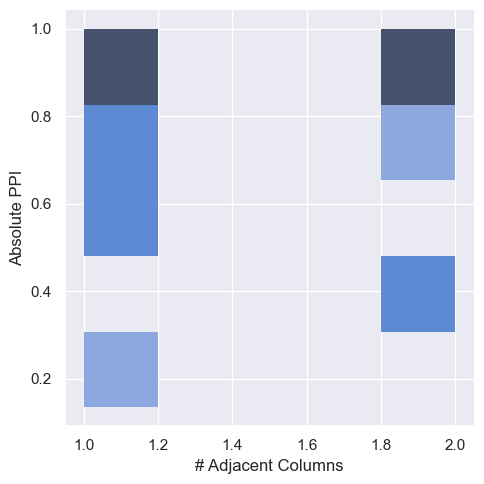

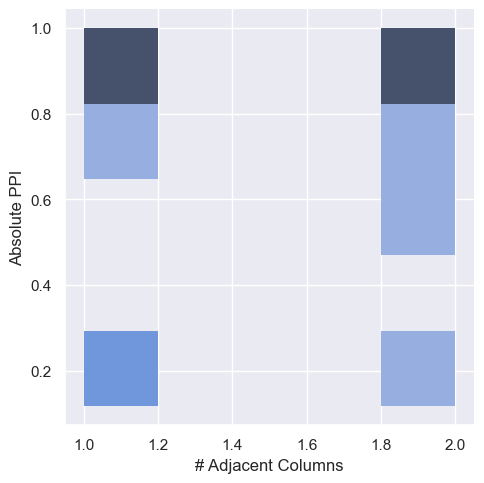

In [83]:
#---MAKE SOME PLOTS WITH DATA TABLES---

#lOAD RELEVANT DATA TABLES
NCsummary = pd.read_csv('Summary_table_NC')
FCsummary = pd.read_csv('Summary_table_FC')

#Plot that data
sns.set_theme()

#NCsummary.plot(x = '# Adjacent Columns', y = 'PPI', style = 'o')
displot(NCsummary, "# Adjacent Columns", 'Absolute PPI')
displot(FCsummary, '# Adjacent Columns', 'Absolute PPI')


#Good to see some sort of distribution?
#Hard to say what the various colors mean - does dark mean more values there?
#How do I change that?

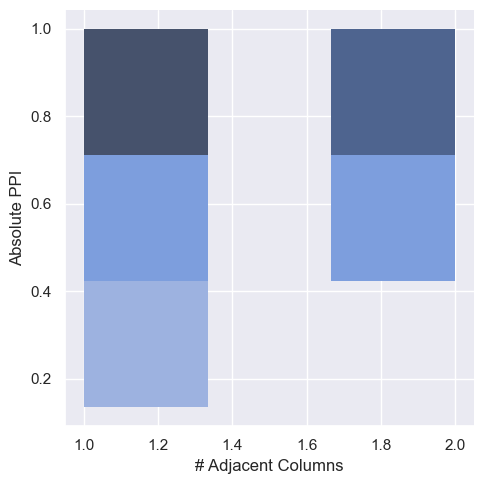

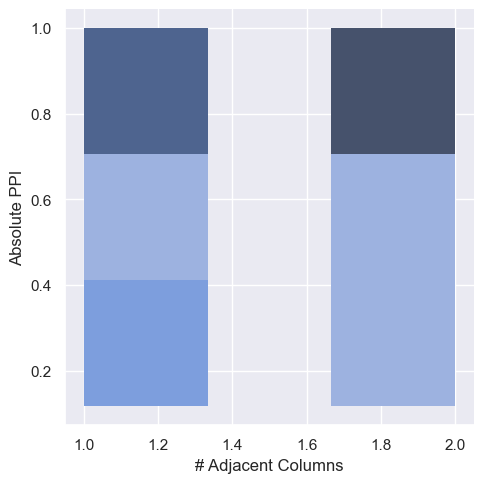

In [57]:
#Messed with different parameters here including bin size
sns.displot(NCsummary, 
            x = '# Adjacent Columns',
            y = 'Absolute PPI',
            bins = 3,
            legend = True,
            #hue = 'PPI'
           )
#sns.displot(NCsummary, x = '# Adjacent Columns', y = 'Absolute PPI', hue = 'Right', binwidth = 1)
sns.displot(FCsummary, 
            x = '# Adjacent Columns',
            y = 'Absolute PPI',
            bins = 3,
            legend = True,
            #hue = 'PPI'
           )

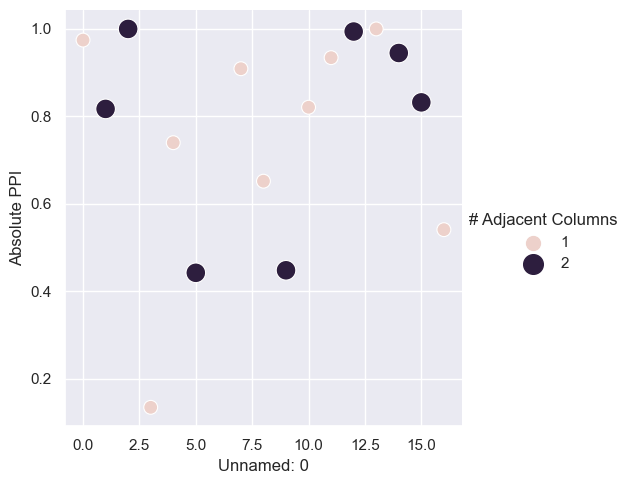

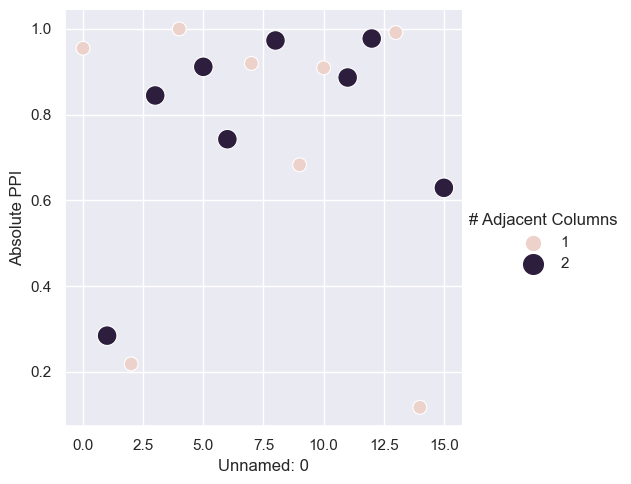

In [205]:
sns.relplot(NCsummary, x = 'Unnamed: 0', y = 'Absolute PPI', size = '# Adjacent Columns', hue = '# Adjacent Columns', sizes = [100,200])
#I am for no good reason, having great difficulty making this scatter plot
sns.relplot(FCsummary, x = 'Unnamed: 0', y = 'Absolute PPI', size = '# Adjacent Columns', hue = '# Adjacent Columns', sizes = [100,200])


(0.0, 1.05)

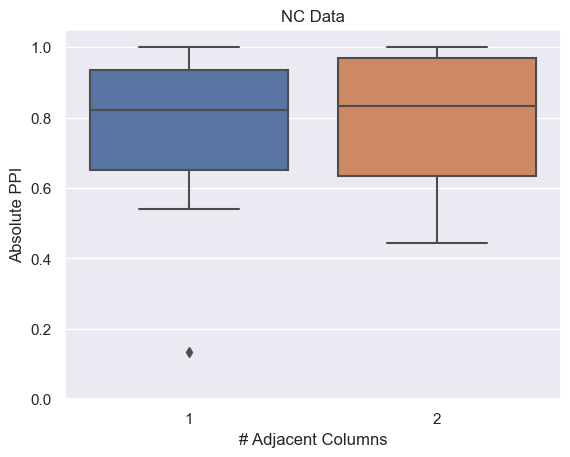

In [122]:
sns.boxplot(NCsummary, x = '# Adjacent Columns', y = 'Absolute PPI').set(title = "NC Data")
plt.ylim(0, 1.05)

(0.0, 1.05)

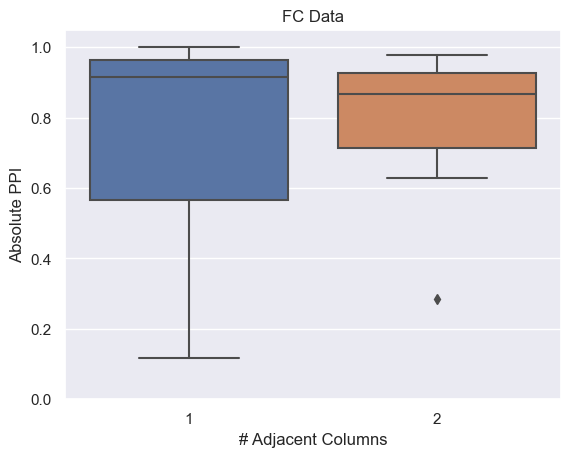

In [123]:
sns.boxplot(FCsummary, x = '# Adjacent Columns', y = 'Absolute PPI').set(title = "FC Data")
plt.ylim(0, 1.05)

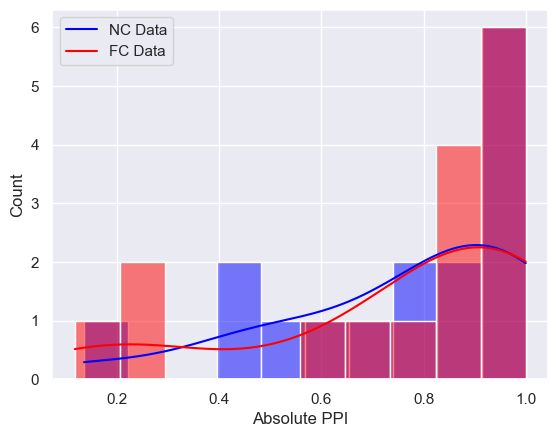

In [163]:
sns.histplot(NCsummary, x = 'Absolute PPI', #hue = 'Left', 
            color = 'blue', bins = 10, kde = True, #element = 'step'
            )
sns.histplot(FCsummary, x = 'Absolute PPI', #hue = '# Adjacent Columns'
            color = 'red', bins = 10, kde = True, #element = 'step'
            )
plt.legend(labels = ['NC Data', 'FC Data'])

<AxesSubplot:xlabel='Absolute PPI', ylabel='Count'>

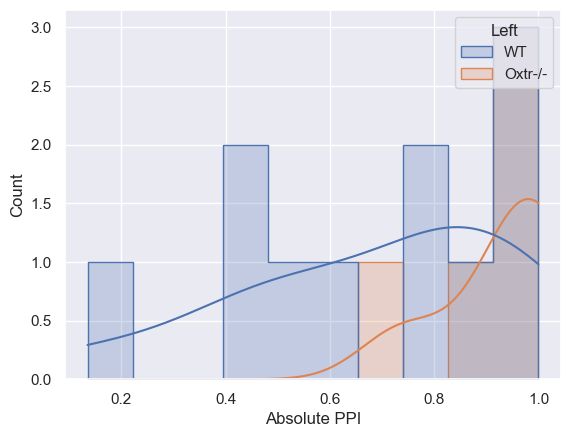

In [173]:
sns.histplot(NCsummary, x = 'Absolute PPI', hue = 'Left', 
            color = 'blue', bins = 10, kde = True, element = 'step')


<AxesSubplot:xlabel='Absolute PPI', ylabel='Count'>

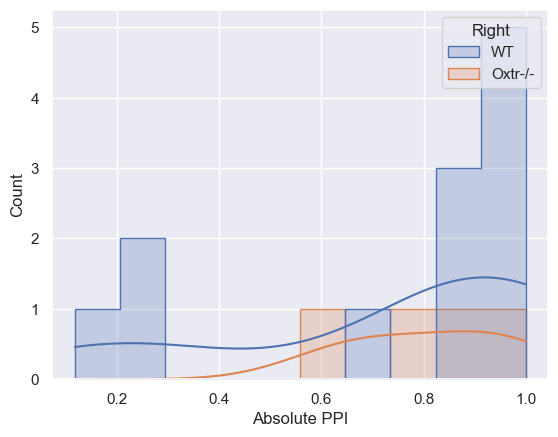

In [167]:
sns.histplot(FCsummary, x = 'Absolute PPI', hue = 'Right', 
            color = 'blue', bins = 10, kde = True, element = 'step')

In [ ]:
And I do think the categories-only display is really compelling,
but in addition seeing a scatter plot with the actual values,
maybe colored by group, would also be interesting.  
Just so we know how much the "chose right" group in the 1 adjacent
lane category is like the "chose right" group in 2 adjacent lane category

AttributeError: 'DataFrame' object has no attribute 'column'